#### Install dditional libraries ##########

In [1]:
%%capture
!pip install optuna
!pip install shap
!pip install hyperopt
!pip install imbalanced-learn
!pip install awswrangler

In [2]:
%%capture
!pip install xgboost
!pip install catboost
!pip install tune-sklearn ray[tune]
!pip install pycaret==2.3.1
!pip install scikit-optimize

In [1]:
# import torch
# # If there"s a GPU available...
# if torch.cuda.is_available():    
#     # Tell PyTorch to use the GPU.    
#     device = torch.device("cuda")
#     print("There are %d GPU(s) available." % torch.cuda.device_count())
#     print("We will use the GPU:", torch.cuda.get_device_name(0))
# # If not...
# else:
#     print("No GPU available, using the CPU instead.")
#     device = torch.device("cpu")

In [2]:
import numpy as np
import pandas as pd
from pandas.api.types import is_string_dtype, is_numeric_dtype
from datetime import datetime, date, timedelta
import os
import math
import warnings 
import pyodbc
import time
import pickle
import boto3
from io import BytesIO
import re
import awswrangler as wr
%matplotlib inline
import matplotlib.pyplot as plt
import missingno
import warnings
import seaborn as sns

#from pandas_profiling import ProfileReport
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')

Matplotlib is building the font cache; this may take a moment.


In [3]:
import optuna, shap
from hyperopt import tpe, hp, fmin
import hyperopt
import pycaret
pycaret.__version__

'2.3.1'

In [5]:
import multiprocessing
import os

print(multiprocessing.cpu_count())
# print(os.cpu_count())

64


In [6]:
import time
start_time = time.time()
from io import BytesIO


df = wr.s3.read_csv("s3://daan888/projectcr/data/semiprocessed/mortgage_risk_unique_semi_processed.csv", skip_blank_lines=True)

df.reset_index(drop=True, inplace=True)

### clean columns names

df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

print("--- %s seconds ---" % (time.time() - start_time))  

--- 0.7498493194580078 seconds ---


In [7]:
df.shape

(50000, 17)

In [8]:
df.columns

Index(['balance_time', 'ltv_time', 'interest_rate_time', 'hpi_time',
       'gdp_time', 'uer_time', 'retype_co_orig_time', 'retype_pu_orig_time',
       'retype_sf_orig_time', 'investor_orig_time', 'balance_orig_time',
       'fico_orig_time', 'ltv_orig_time', 'interest_rate_orig_time',
       'hpi_orig_time', 'default_time', 'max_periods'],
      dtype='object')

In [9]:
#### rename target

df.rename(columns={'default_time': 'default'}, inplace=True)

In [10]:
def movecol(df, cols_to_move=[], ref_col='', place='After'):
    
    cols = df.columns.tolist()
    if place == 'After':
        seg1 = cols[:list(cols).index(ref_col) + 1]
        seg2 = cols_to_move
    if place == 'Before':
        seg1 = cols[:list(cols).index(ref_col)]
        seg2 = cols_to_move + [ref_col]
    
    seg1 = [i for i in seg1 if i not in seg2]
    seg3 = [i for i in cols if i not in seg1 + seg2]
    
    return(df[seg1 + seg2 + seg3])

In [11]:
df= movecol(df, 
             cols_to_move=['default'], 
             ref_col='balance_time',
             place='Before')

df.reset_index(drop=True, inplace=True)

In [12]:
from pandas import option_context

with option_context('display.max_rows', None,'display.max_colwidth',150,'display.max_columns',50):
              display(df.head(2))

,default,balance_time,ltv_time,interest_rate_time,hpi_time,gdp_time,uer_time,retype_co_orig_time,retype_pu_orig_time,retype_sf_orig_time,investor_orig_time,balance_orig_time,fico_orig_time,ltv_orig_time,interest_rate_orig_time,hpi_orig_time,max_periods
0,1,29087.21,26.658065,9.20,146.45,2.715903,8.3,0,0,1,0,45000.0,715,69.4,9.20,87.03,24
1,0,105654.77,65.469851,7.68,225.10,2.151365,4.7,0,0,1,0,107200.0,558,80.0,7.68,186.91,2


In [13]:
############ HPO Model first ###########

In [14]:
#### Import modules for feature engineering and modelling
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from imblearn.pipeline import make_pipeline, Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import lightgbm as lgb
from skopt import BayesSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import *

In [15]:
df.columns

Index(['default', 'balance_time', 'ltv_time', 'interest_rate_time', 'hpi_time',
       'gdp_time', 'uer_time', 'retype_co_orig_time', 'retype_pu_orig_time',
       'retype_sf_orig_time', 'investor_orig_time', 'balance_orig_time',
       'fico_orig_time', 'ltv_orig_time', 'interest_rate_orig_time',
       'hpi_orig_time', 'max_periods'],
      dtype='object')

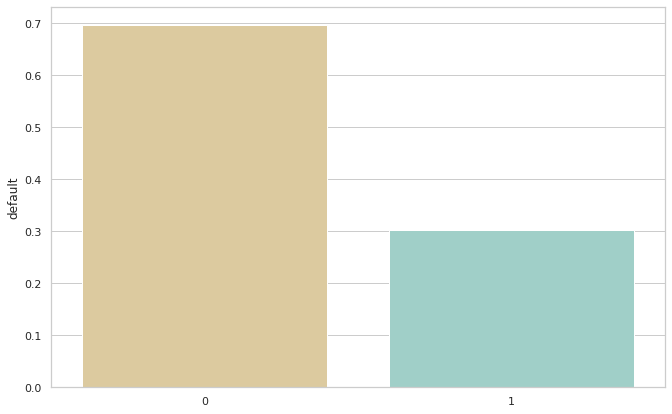

In [16]:
sns.set(style="whitegrid")
plt.figure(figsize=(11,7))
sns.barplot(x=df.default.value_counts(normalize=True).index, y=df.default.value_counts(normalize=True),
           palette = 'BrBG')
plt.show()

In [17]:
# Partition data
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['default']), 
                                                    df['default'], 
                                                    test_size=.20, 
                                                    random_state=101,
                                                   stratify=df['default'])

# Define categorical columns
categorical = list(X_train.select_dtypes(['category','O']).columns)
print(f"Categorical columns are: {categorical}")

# Define numerical columns
numerical = list(X_train.select_dtypes('number').columns)
print(f"Numerical columns are: {numerical}")

Categorical columns are: []
Numerical columns are: ['balance_time', 'ltv_time', 'interest_rate_time', 'hpi_time', 'gdp_time', 'uer_time', 'retype_co_orig_time', 'retype_pu_orig_time', 'retype_sf_orig_time', 'investor_orig_time', 'balance_orig_time', 'fico_orig_time', 'ltv_orig_time', 'interest_rate_orig_time', 'hpi_orig_time', 'max_periods']


In [18]:
smote = SMOTE(random_state=101)

In [19]:
from tune_sklearn import TuneSearchCV
from tune_sklearn import TuneGridSearchCV
from ray import tune

from sklearn.feature_selection import SelectKBest, chi2

In [20]:
# if more than one evaluation metric are given the last one is used for early stopping
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=101)

In [21]:
xgb_model 

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=101, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None)

In [22]:
from imblearn.pipeline import Pipeline
from imblearn import FunctionSampler
# Define categorical pipelin

# Define categorical pipeline
cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

# Define numerical pipeline
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])


# Combine categorical and numerical pipelines
preprocessor = ColumnTransformer([
    ('cat', cat_pipe, categorical),
    ('num', num_pipe, numerical)
])

# Fit a pipeline with transformers and an estimator to the training data
pipe_baseline = Pipeline([
    # ('Outlier_removal', FunctionSampler(func=CustomSampler_IQR, validate = False)),
    ('preprocessor', preprocessor),
    ('sm', smote),
    ('xgb', xgb_model)
])

In [23]:
# np.arange(0.05, 1, 0.02)

In [24]:
# A parameter grid for XGBoost
search_space = {
        # You can mix constants with search space objects.
        "xgb__max_depth": tune.randint(1, 9),
        "xgb__min_child_weight": tune.choice([1, 2, 3]),
        "xgb__subsample": tune.uniform(0.5, 1.0),
        "xgb__eta": tune.loguniform(1e-4, 1e-1),
        "xgb__learning_rate":tune.choice([0.02,0.03,0.05,0.07, 0.1 , 0.15, 0.2 , 0.3 , 0.4 , 0.45, 0.5 , 0.55,
       0.6 ,  0.7 , 0.75, 0.8 , 0.9 , 0.95]),
    }


In [25]:
import sklearn
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

In [26]:
credit_risk_init = TuneSearchCV(
    pipe_baseline,
    search_space,
    n_trials=5,
    search_optimization="bayesian",
    early_stopping=True,
    scoring=("accuracy", "f1","roc_auc"),
    refit="f1",
    max_iters=50,
    pipeline_auto_early_stop=True)

In [27]:
credit_risk_init 

TuneSearchCV(early_stopping=<ray.tune.schedulers.async_hyperband.AsyncHyperBandScheduler object at 0x7f7ca45fddd8>,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value='missing',
                                                                                                        strategy='constant')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                          

In [ ]:
import datetime
start = datetime.datetime.now()

credit_risk_init.fit(X_train,y_train)

end = datetime.datetime.now()
process_time = end - start
print("It took: " + str(process_time.seconds/60) + " minutes.")

(pid=14778) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=14778) 
(pid=14778) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=14778) 
(pid=14771) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=14771) 
(pid=14771) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=14771) 
(pid=14775) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/si

(pid=14778) [16:48:47] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
(pid=14771) [16:48:47] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


(pid=14779) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=14779) 
(pid=14779) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=14779) 
(pid=14764) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=14764) 
(pid=14764) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=14764) 


(pid=14775) [16:48:48] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
(pid=14779) [16:48:48] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
(pid=14764) [16:48:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


(pid=14771) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=14771) 
(pid=14771) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=14771) 


(pid=14771) [16:49:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


(pid=14778) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=14778) 
(pid=14778) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=14778) 


(pid=14778) [16:49:26] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


(pid=14779) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=14779) 
(pid=14779) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=14779) 


(pid=14779) [16:49:27] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


(pid=14771) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=14771) 
(pid=14771) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=14771) 


(pid=14771) [16:49:39] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


(pid=14779) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=14779) 
(pid=14779) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=14779) 
(pid=14778) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=14778) 
(pid=14778) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=14778) 


(pid=14779) [16:50:05] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


(pid=14771) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=14771) 
(pid=14771) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=14771) 


(pid=14778) [16:50:05] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


(pid=14775) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=14775) 
(pid=14775) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=14775) 


(pid=14771) [16:50:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
(pid=14775) [16:50:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


(pid=14771) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=14771) 
(pid=14771) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=14771) 


(pid=14771) [16:50:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


(pid=14779) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=14779) 
(pid=14779) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=14779) 


(pid=14779) [16:50:44] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


(pid=14778) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=14778) 
(pid=14778) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=14778) 


(pid=14778) [16:50:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


(pid=14771) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=14771) 
(pid=14771) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=14771) 
(pid=14764) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=14764) 
(pid=14764) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=14764) 


(pid=14764) [16:51:20] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


(pid=14779) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=14779) 
(pid=14779) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=14779) 


(pid=14779) [16:51:22] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


(pid=14778) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=14778) 
(pid=14778) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=14778) 


(pid=14778) [16:51:23] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


(pid=14775) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=14775) 
(pid=14775) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=14775) 
(pid=14771) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=14771) 
(pid=14771) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=14771) 


(pid=14775) [16:51:24] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


(pid=14771) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=14771) 
(pid=14771) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=14771) 
(pid=14779) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=14779) 
(pid=14779) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=14779) 
(pid=14778) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/si

(pid=14775) [16:52:41] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


(pid=14771) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=14771) 
(pid=14771) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=14771) 
(pid=14779) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=14779) 
(pid=14779) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=14779) 
(pid=14778) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/si

(pid=14764) [16:53:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


(pid=14779) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=14779) 
(pid=14779) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=14779) 
(pid=14778) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=14778) 
(pid=14778) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=14778) 
(pid=14775) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/si

(pid=14775) [16:53:57] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


(pid=14771) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=14771) 
(pid=14771) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=14771) 
(pid=14771) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=14771) 
(pid=14771) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=14771) 
(pid=14779) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/si

(pid=14764) [16:56:13] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


(pid=14775) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=14775) 
(pid=14775) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=14775) 
(pid=14778) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=14778) 
(pid=14778) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=14778) 
(pid=14779) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/si

(pid=14764) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=14764) 
(pid=14764) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=14764) 


(pid=14764) [16:58:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


(pid=14775) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=14775) 
(pid=14775) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=14775) 
(pid=14778) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=14778) 
(pid=14778) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=14778) 
(pid=14779) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/si

(pid=14764) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=14764) 
(pid=14764) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=14764) 
(pid=14771) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=14771) 
(pid=14771) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=14771) 
(pid=14778) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/si

(pid=14771) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=14771) 
(pid=14771) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=14771) 
(pid=14778) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=14778) 
(pid=14778) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=14778) 
(pid=14775) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/si

(pid=14771) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=14771) 
(pid=14771) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=14771) 
(pid=14778) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=14778) 
(pid=14778) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=14778) 
(pid=14771) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/si

(pid=14764) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=14764) 
(pid=14764) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=14764) 
(pid=14775) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=14775) 
(pid=14775) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=14775) 
(pid=14778) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/si

(pid=14771) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=14771) 
(pid=14771) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=14771) 
(pid=14775) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=14775) 
(pid=14775) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=14775) 
(pid=14778) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/si

(pid=14771) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=14771) 
(pid=14771) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=14771) 
(pid=14771) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=14771) 
(pid=14771) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=14771) 
(pid=14778) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/si

(pid=14775) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=14775) 
(pid=14775) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=14775) 
(pid=14771) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=14771) 
(pid=14771) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=14771) 
(pid=14771) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/si

(pid=14771) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=14771) 
(pid=14771) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=14771) 
(pid=14775) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=14775) 
(pid=14775) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=14775) 
(pid=14771) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/si

(pid=14771) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=14771) 
(pid=14771) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=14771) 
(pid=14764) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=14764) 
(pid=14764) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=14764) 
(pid=14775) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/si

(pid=14778) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=14778) 
(pid=14778) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=14778) 
(pid=14771) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=14771) 
(pid=14771) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=14771) 
(pid=14778) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/si

(pid=14775) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=14775) 
(pid=14775) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=14775) 
(pid=14771) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=14771) 
(pid=14771) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=14771) 
(pid=14778) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/si

(pid=14775) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=14775) 
(pid=14775) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=14775) 
(pid=14771) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=14771) 
(pid=14771) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=14771) 
(pid=14778) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/si

(pid=14775) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=14775) 
(pid=14775) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=14775) 
(pid=14778) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=14778) 
(pid=14778) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=14778) 
(pid=14771) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/si

(pid=14778) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=14778) 
(pid=14778) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=14778) 
(pid=14771) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=14771) 
(pid=14771) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=14771) 
(pid=14771) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/si

In [32]:
print(credit_risk_init.best_params_)

{'xgb__max_depth': 5, 'xgb__min_child_weight': 2, 'xgb__subsample': 0.9762700395772288, 'xgb__eta': 0.09470681429467549, 'xgb__learning_rate': 0.05}


In [34]:
#credit_risk.cv_results_

print(credit_risk_init.best_params_)

print('------------')


print(credit_risk_init.best_score_)

{'xgb__max_depth': 5, 'xgb__min_child_weight': 2, 'xgb__subsample': 0.9762700395772288, 'xgb__eta': 0.09470681429467549, 'xgb__learning_rate': 0.05}
------------
0.7177272073988953


In [35]:
predict0 = credit_risk_init.predict(X_test)
#print('Best AUC Score: {}'.format(model.best_score_))
print('Accuracy: {}'.format(accuracy_score(y_test, predict0)))
print(confusion_matrix(y_test,predict0))

Accuracy: 0.8162
[[5802 1167]
 [ 671 2360]]


In [36]:
from sklearn.metrics import classification_report
print(classification_report(y_test,predict0))

              precision    recall  f1-score   support

           0       0.90      0.83      0.86      6969
           1       0.67      0.78      0.72      3031

    accuracy                           0.82     10000
   macro avg       0.78      0.81      0.79     10000
weighted avg       0.83      0.82      0.82     10000



In [37]:
roc_auc_score(y_test,predict0)

0.8055825205833308

In [ ]:
############ Now auto ml First auto ml then try beat it ###########

In [38]:
from pandas import option_context

with option_context('display.max_rows', None,'display.max_colwidth',150,'display.max_columns',50):
              display(df.head(2))

,default,balance_time,ltv_time,interest_rate_time,hpi_time,gdp_time,uer_time,retype_co_orig_time,retype_pu_orig_time,retype_sf_orig_time,investor_orig_time,balance_orig_time,fico_orig_time,ltv_orig_time,interest_rate_orig_time,hpi_orig_time,max_periods
0,1,29087.21,26.658065,9.20,146.45,2.715903,8.3,0,0,1,0,45000.0,715,69.4,9.20,87.03,24
1,0,105654.77,65.469851,7.68,225.10,2.151365,4.7,0,0,1,0,107200.0,558,80.0,7.68,186.91,2


In [39]:
from pycaret.classification import *

In [40]:
import time

start_time = time.time()

exp01 = setup(data = df, target = 'default',session_id=123,train_size = 0.8,
                 normalize=True,
                feature_selection=True, remove_outliers=True,
                remove_multicollinearity=True, #fix_imbalance=False, 
               #feature_interaction = True, feature_ratio = True
                bin_numeric_features=["max_periods", "fico_orig_time","balance_orig_time"],
                silent=True, experiment_name="test_defaultv2",
                log_experiment=True)

print("--- %s seconds ---" % (time.time() - start_time))

,Description,Value
0,session_id,123
1,Target,default
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(50000, 17)"
5,Missing Values,True
6,Numeric Features,12
7,Categorical Features,4
8,Ordinal Features,False
9,High Cardinality Features,False


--- 7.169614791870117 seconds ---


In [41]:
exp01

('default',
        fico_orig_time_14.0  fico_orig_time_13.0  fico_orig_time_2.0  \
 0                      0.0                  0.0                 0.0   
 1                      0.0                  0.0                 0.0   
 2                      0.0                  0.0                 0.0   
 3                      0.0                  0.0                 0.0   
 4                      0.0                  0.0                 0.0   
 ...                    ...                  ...                 ...   
 49995                  0.0                  0.0                 0.0   
 49996                  0.0                  0.0                 0.0   
 49997                  1.0                  0.0                 0.0   
 49998                  0.0                  0.0                 0.0   
 49999                  0.0                  0.0                 0.0   
 
        fico_orig_time_10.0  balance_orig_time_4.0  gdp_time  \
 0                      0.0                    0.0  0.5358

In [42]:
data_transforx = get_config('X_train')

In [43]:

from pandas import option_context

with option_context('display.max_rows', None,'display.max_colwidth',60,'display.max_columns',200):
        display(data_transforx.head(5))

,fico_orig_time_14.0,fico_orig_time_13.0,fico_orig_time_2.0,fico_orig_time_10.0,balance_orig_time_4.0,gdp_time,fico_orig_time_15.0,retype_pu_orig_time_0,max_periods_3.0,fico_orig_time_8.0,fico_orig_time_4.0,balance_orig_time_5.0,max_periods_6.0,fico_orig_time_11.0,max_periods_2.0,interest_rate_time,fico_orig_time_7.0,fico_orig_time_6.0,fico_orig_time_9.0,max_periods_13.0,balance_orig_time_2.0,max_periods_8.0,fico_orig_time_3.0,balance_orig_time_0.0,uer_time,balance_orig_time_1.0,max_periods_12.0,fico_orig_time_16.0,max_periods_7.0,fico_orig_time_12.0,ltv_time,max_periods_10.0,hpi_orig_time,max_periods_0.0,retype_sf_orig_time_0,investor_orig_time_0,max_periods_1.0,max_periods_4.0,max_periods_11.0,balance_orig_time_3.0,hpi_time,ltv_orig_time,max_periods_5.0,interest_rate_orig_time,retype_co_orig_time_1,max_periods_9.0,fico_orig_time_5.0,balance_time
32815,0.0,0.0,0.0,0.0,1.0,0.242721,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.780041,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.777272,0.0,0.0,0.0,0.0,0.0,-0.208981,0.0,0.365802,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.325254,0.030591,0.0,-1.653645,0.0,0.0,0.0,1.112729
35141,0.0,0.0,0.0,0.0,0.0,-3.027630,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.836452,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.791975,0.0,0.0,0.0,0.0,0.0,1.456256,0.0,0.797133,0.0,1.0,1.0,0.0,0.0,0.0,0.0,-1.404103,0.030591,0.0,0.841843,1.0,0.0,0.0,-0.079832
19390,0.0,0.0,0.0,0.0,0.0,0.535864,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.532824,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.373725,0.0,0.0,0.0,0.0,0.0,-0.679753,1.0,-1.172100,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.666578,-1.481259,0.0,-1.653645,0.0,0.0,0.0,-0.841204
34846,0.0,0.0,0.0,0.0,0.0,0.598412,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.283621,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.179773,0.0,0.0,1.0,0.0,0.0,-1.491968,1.0,0.743833,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.016791,-1.219205,0.0,0.668798,0.0,0.0,0.0,-1.096332
8039,0.0,0.0,0.0,0.0,0.0,0.604403,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.359558,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.255271,0.0,0.0,0.0,0.0,0.0,-0.051978,0.0,-2.471887,1.0,1.0,1.0,0.0,0.0,0.0,0.0,-2.917707,0.030591,0.0,2.065300,0.0,0.0,1.0,-0.743585


In [44]:
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [45]:
import time

start = time.time()

modelsexp = compare_models(round = 5, fold=3,  sort = "AUC",
                            include = ['lr','knn','lightgbm','nb','svm','rf','xgboost','catboost']
                          )
#                             exclude = ['catboost', 'svm','xgboost','qda','lightgbm'])

end = time.time()

print(end - start)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.82703,0.89203,0.68191,0.74073,0.71007,0.58712,0.58817,4.09000
lightgbm,Light Gradient Boosting Machine,0.82600,0.88999,0.68420,0.73691,0.70954,0.58559,0.58644,0.95000
xgboost,Extreme Gradient Boosting,0.82124,0.88614,0.67675,0.72859,0.70167,0.57431,0.57514,19.20333
rf,Random Forest Classifier,0.82316,0.88415,0.66675,0.73860,0.70080,0.57576,0.57730,0.92667
lr,Logistic Regression,0.80811,0.85541,0.58695,0.74147,0.65520,0.52475,0.53164,1.17000
knn,K Neighbors Classifier,0.79384,0.82804,0.62728,0.68325,0.65400,0.50757,0.50856,7.04000
nb,Naive Bayes,0.65805,0.80760,0.87175,0.47281,0.61305,0.35197,0.40562,0.50667
svm,SVM - Linear Kernel,0.80658,0.00000,0.63109,0.71348,0.66965,0.53364,0.53574,0.55667


118.39805173873901


In [46]:
import time

start = time.time()

catboost_cr = create_model('catboost', fold = 10)


end = time.time()

print(end - start)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8226,0.8843,0.6842,0.7286,0.7057,0.5789,0.5795
1,0.8368,0.9024,0.6943,0.7600,0.7257,0.6099,0.6112
2,0.8368,0.8974,0.7113,0.7507,0.7304,0.6136,0.6140
3,0.8282,0.8967,0.6816,0.7440,0.7114,0.5894,0.5906
4,0.8313,0.8977,0.6825,0.7519,0.7155,0.5960,0.5974
5,0.8358,0.9007,0.6907,0.7588,0.7232,0.6068,0.6082
6,0.8245,0.8862,0.6924,0.7288,0.7101,0.5844,0.5848
7,0.8224,0.8875,0.6568,0.7416,0.6966,0.5717,0.5738
8,0.8224,0.8905,0.6754,0.7319,0.7025,0.5762,0.5771
9,0.8292,0.8933,0.6763,0.7493,0.7109,0.5902,0.5917


114.25063371658325


In [49]:
import time
start_time = time.time()


catboost_cr_tune= tune_model(catboost_cr, n_iter=25, fold = 10,optimize = 'F1',search_library='optuna',
                             search_algorithm='tpe',choose_better=True)


print("--- %s seconds ---" % (time.time() - start_time))

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8147,0.8680,0.6672,0.7170,0.6912,0.5591,0.5599
1,0.8274,0.8871,0.6765,0.7446,0.7090,0.5867,0.5880
2,0.8237,0.8843,0.6969,0.7251,0.7107,0.5840,0.5842
3,0.8189,0.8829,0.6681,0.7272,0.6964,0.5677,0.5688
4,0.8213,0.8835,0.6647,0.7350,0.6981,0.5717,0.5731
5,0.8253,0.8863,0.6873,0.7333,0.7095,0.5848,0.5854
6,0.8174,0.8715,0.6788,0.7177,0.6977,0.5670,0.5675
7,0.8100,0.8736,0.6441,0.7156,0.6780,0.5437,0.5453
8,0.8147,0.8759,0.6619,0.7192,0.6893,0.5577,0.5586
9,0.8195,0.8789,0.6568,0.7339,0.6932,0.5659,0.5676


--- 293.5170741081238 seconds ---


In [50]:
catboost_cr_tune

In [51]:
catboost_cr_tune_f1_model =catboost_cr_tune
plot_model(catboost_cr_tune_f1_model, plot="parameter")
print(f"Model: {type(catboost_cr_tune)}")

,Parameters
nan_mode,Min
eval_metric,Logloss
iterations,1000
sampling_frequency,PerTree
leaf_estimation_method,Newton
grow_policy,SymmetricTree
penalties_coefficient,1
boosting_type,Plain
model_shrink_mode,Constant
feature_border_type,GreedyLogSum


Model: <class 'catboost.core.CatBoostClassifier'>


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


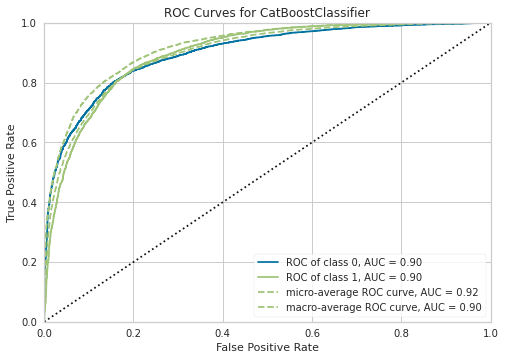

In [52]:
# plotting a model
plot_model(catboost_cr_tune)

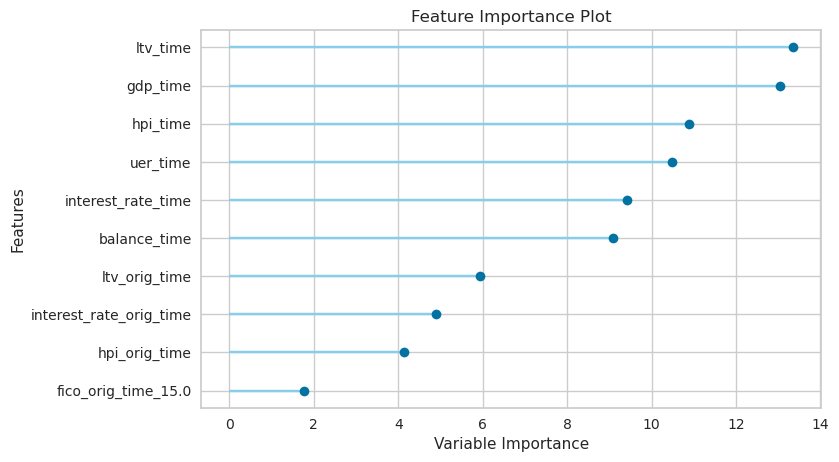

In [53]:
plot_model(catboost_cr_tune, plot = 'feature')

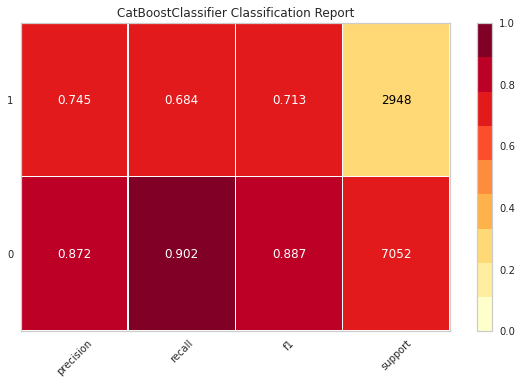

In [44]:
plot_model(catboost_cr_tune, plot = 'class_report')

In [45]:
import shap

In [46]:
# interpret_model(lightgbm_cr_tune, plot = 'reason')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


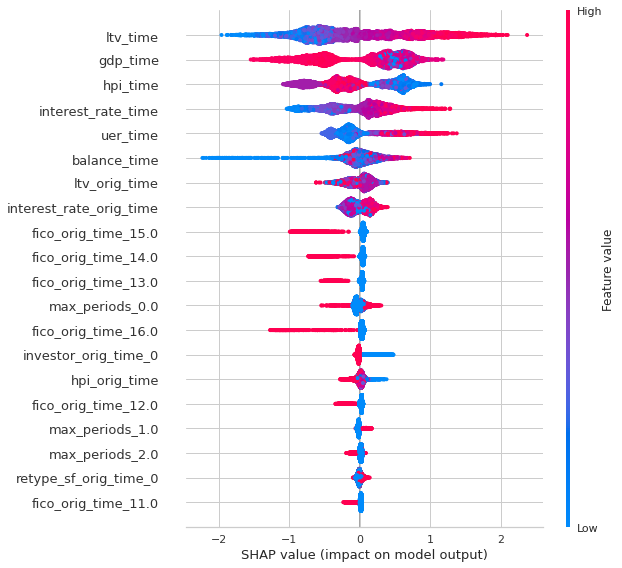

In [47]:
# interpreting model
interpret_model(catboost_cr_tune)

In [54]:
pred_holdouts = predict_model(catboost_cr_tune)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.8335,0.8996,0.6825,0.7340,0.7073,0.5912,0.5920


In [55]:
from pandas import option_context

with option_context('display.max_rows', None,'display.max_colwidth',50,'display.max_columns',50):
        display(pred_holdouts.head(5))

,fico_orig_time_14.0,fico_orig_time_13.0,fico_orig_time_2.0,fico_orig_time_10.0,balance_orig_time_4.0,gdp_time,fico_orig_time_15.0,retype_pu_orig_time_0,max_periods_3.0,fico_orig_time_8.0,fico_orig_time_4.0,balance_orig_time_5.0,max_periods_6.0,fico_orig_time_11.0,max_periods_2.0,interest_rate_time,fico_orig_time_7.0,fico_orig_time_6.0,fico_orig_time_9.0,max_periods_13.0,balance_orig_time_2.0,max_periods_8.0,fico_orig_time_3.0,balance_orig_time_0.0,uer_time,...,max_periods_12.0,fico_orig_time_16.0,max_periods_7.0,fico_orig_time_12.0,ltv_time,max_periods_10.0,hpi_orig_time,max_periods_0.0,retype_sf_orig_time_0,investor_orig_time_0,max_periods_1.0,max_periods_4.0,max_periods_11.0,balance_orig_time_3.0,hpi_time,ltv_orig_time,max_periods_5.0,interest_rate_orig_time,retype_co_orig_time_1,max_periods_9.0,fico_orig_time_5.0,balance_time,default,Label,Score
0,0.0,0.0,0.0,0.0,1.0,0.719464,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.573831,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.299272,...,0.0,0.0,0.0,0.0,-0.933278,0.0,-1.172100,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.044073,-1.017625,0.0,0.091982,0.0,0.0,0.0,1.139060,0,0,0.9796
1,0.0,0.0,0.0,0.0,0.0,0.631010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.291775,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.777272,...,0.0,0.0,0.0,0.0,-0.414225,0.0,-0.820431,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.370521,1.542442,0.0,0.281724,0.0,0.0,0.0,-0.570843,0,0,0.9355
2,0.0,0.0,0.0,0.0,0.0,0.828153,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.238492,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.598022,...,0.0,0.0,0.0,0.0,-1.319106,0.0,-1.668899,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.008382,-0.553991,0.0,0.638439,0.0,0.0,0.0,-0.596330,0,0,0.9310
3,0.0,0.0,0.0,0.0,0.0,0.351951,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.306185,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.956521,...,0.0,0.0,0.0,0.0,-0.525463,0.0,-0.270042,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.222166,0.030591,0.0,0.683977,0.0,0.0,0.0,0.386895,0,0,0.8341
4,0.0,0.0,0.0,0.0,0.0,0.351951,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.892863,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.956521,...,0.0,0.0,0.0,0.0,0.427561,0.0,0.757737,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.222166,1.038492,0.0,1.078641,0.0,0.0,0.0,-0.246514,0,0,0.8754


In [ ]:
########## Light GBM ###############

In [57]:
import time

start = time.time()

lightgbm_cr = create_model('lightgbm', fold = 10)


end = time.time()

print(end - start)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8158,0.8831,0.6740,0.7165,0.6946,0.5629,0.5634
1,0.8321,0.9003,0.6960,0.7466,0.7204,0.6007,0.6014
2,0.8300,0.8943,0.7028,0.7378,0.7199,0.5979,0.5983
3,0.8321,0.8947,0.6943,0.7475,0.7199,0.6003,0.6011
4,0.8303,0.8942,0.6850,0.7477,0.7150,0.5945,0.5956
5,0.8311,0.8973,0.6864,0.7486,0.7162,0.5962,0.5974
6,0.8208,0.8853,0.6856,0.7230,0.7038,0.5754,0.5759
7,0.8250,0.8857,0.6720,0.7404,0.7046,0.5807,0.5820
8,0.8266,0.8890,0.6797,0.7405,0.7088,0.5856,0.5867
9,0.8308,0.8910,0.6788,0.7521,0.7136,0.5940,0.5955


7.013417720794678


In [60]:
# import time
# start_time = time.time()


# catboost_cr_tune= tune_model(catboost_cr, n_iter=25, fold = 10,optimize = 'F1',search_library='optuna',
#                              search_algorithm='tpe',choose_better=True)


# print("--- %s seconds ---" % (time.time() - start_time))

In [68]:
import time
start_time = time.time()


lightgbm_cr_tune= tune_model(lightgbm_cr, n_iter=25, fold = 10, optimize = 'AUC',search_library='tune-sklearn',
                             search_algorithm='hyperopt')


print("--- %s seconds ---" % (time.time() - start_time))

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8218,0.8833,0.6833,0.7270,0.7045,0.5772,0.5777
1,0.8366,0.9028,0.7053,0.7532,0.7285,0.6118,0.6124
2,0.8342,0.8936,0.7062,0.7466,0.7258,0.6072,0.6076
3,0.8266,0.8934,0.6816,0.7399,0.7096,0.5862,0.5872
4,0.8311,0.8952,0.6850,0.7498,0.7159,0.5961,0.5973
5,0.8374,0.8977,0.7008,0.7573,0.7280,0.6123,0.6132
6,0.8232,0.8850,0.6814,0.7309,0.7053,0.5792,0.5799
7,0.8271,0.8864,0.6763,0.7437,0.7084,0.5859,0.5872
8,0.8232,0.8894,0.6703,0.7365,0.7019,0.5766,0.5778
9,0.8287,0.8876,0.6763,0.7479,0.7103,0.5891,0.5906


--- 72.92585945129395 seconds ---


In [69]:
lightgbm_cr_tune

LGBMClassifier(bagging_fraction=0.53425281029823, bagging_freq=1,
               boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               feature_fraction=0.6342354043799849, importance_type='split',
               learning_rate=0.06233797615717307, max_depth=-1,
               min_child_samples=87, min_child_weight=0.001,
               min_split_gain=0.2909305646314325, n_estimators=173, n_jobs=-1,
               num_leaves=111, objective=None, random_state=123,
               reg_alpha=1.4807741723410002e-10,
               reg_lambda=7.126444135377343e-07, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [70]:
lightgbm_cr_tune_auc_model =lightgbm_cr_tune
plot_model(lightgbm_cr_tune_auc_model, plot="parameter")
print(f"Model: {type(lightgbm_cr_tune)}")

,Parameters
boosting_type,gbdt
class_weight,None
colsample_bytree,1.0
importance_type,split
learning_rate,0.06233797615717307
max_depth,-1
min_child_samples,87
min_child_weight,0.001
min_split_gain,0.2909305646314325
n_estimators,173


Model: <class 'lightgbm.sklearn.LGBMClassifier'>


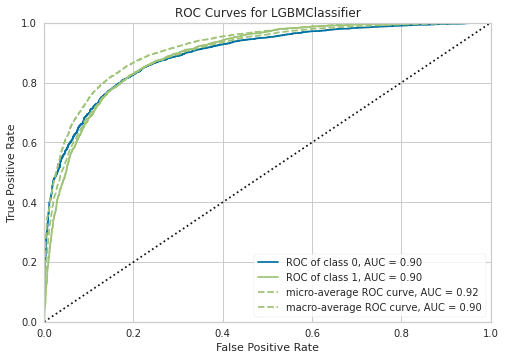

In [71]:
# plotting a model
plot_model(lightgbm_cr_tune)

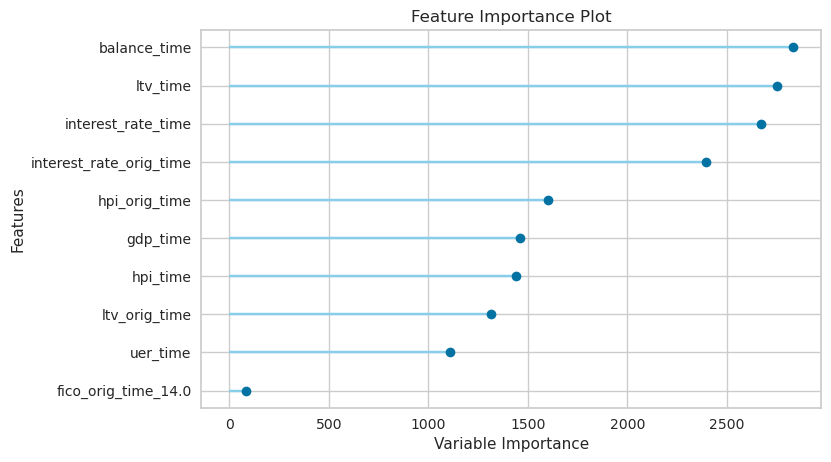

In [72]:
plot_model(lightgbm_cr_tune, plot = 'feature')

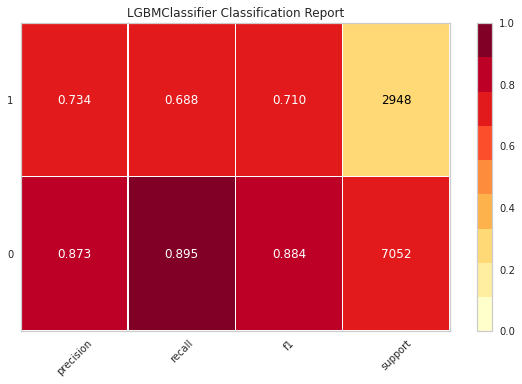

In [73]:
plot_model(lightgbm_cr_tune, plot = 'class_report')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


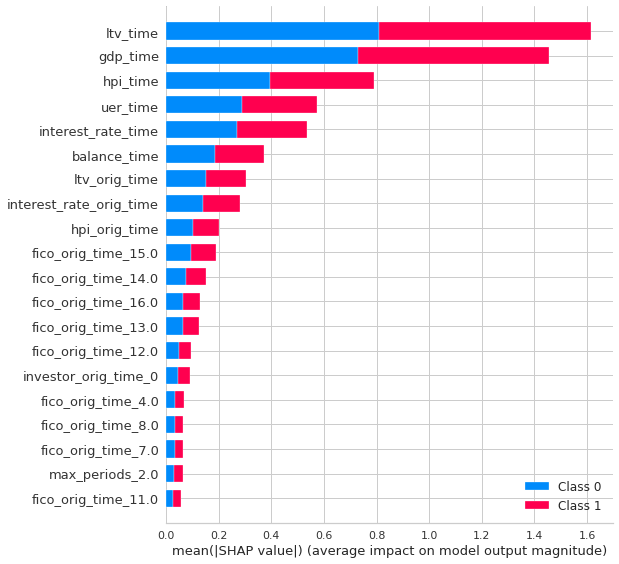

In [74]:
# interpreting model
interpret_model(lightgbm_cr_tune)

In [ ]:
interpret_model(lightgbm_cr_tune, plot = 'reason')

In [25]:
########### Own bayesian optimization #############

In [59]:
# %%capture
# !pip install scikit-optimize

In [14]:
df.columns

Index(['default', 'balance_time', 'ltv_time', 'interest_rate_time', 'hpi_time',
       'gdp_time', 'uer_time', 'retype_co_orig_time', 'retype_pu_orig_time',
       'retype_sf_orig_time', 'investor_orig_time', 'balance_orig_time',
       'fico_orig_time', 'ltv_orig_time', 'interest_rate_orig_time',
       'hpi_orig_time', 'max_periods'],
      dtype='object')

In [15]:
# Partition data
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['default']), 
                                                    df['default'], 
                                                    test_size=.15, 
                                                    random_state=101,
                                                   stratify=df['default'])

# Define categorical columns
categorical = list(X_train.select_dtypes(['category','O']).columns)
print(f"Categorical columns are: {categorical}")

# Define numerical columns
numerical = list(X_train.select_dtypes('number').columns)
print(f"Numerical columns are: {numerical}")

Categorical columns are: []
Numerical columns are: ['balance_time', 'ltv_time', 'interest_rate_time', 'hpi_time', 'gdp_time', 'uer_time', 'retype_co_orig_time', 'retype_pu_orig_time', 'retype_sf_orig_time', 'investor_orig_time', 'balance_orig_time', 'fico_orig_time', 'ltv_orig_time', 'interest_rate_orig_time', 'hpi_orig_time', 'max_periods']


In [16]:
oversamp = RandomOverSampler(random_state=1)
smote = SMOTE(random_state=101)

In [17]:
# if more than one evaluation metric are given the last one is used for early stopping
xgb_model2 = xgb.XGBClassifier(objective="binary:logistic", random_state=101)

In [69]:

# Define categorical pipelin

# Define categorical pipeline
cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

# Define numerical pipeline
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])


# Combine categorical and numerical pipelines
preprocessor = ColumnTransformer([
    ('cat', cat_pipe, categorical),
    ('num', num_pipe, numerical)
])

# Fit a pipeline with transformers and an estimator to the training data
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('sm', smote),
 ('xgb', xgb_model2)
])



In [70]:
pipe 

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value='missing',
                                                                                 missing_values=nan,
                                                                                 strategy='constant',
                                                      

In [71]:
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer
# Define our search space for grid search
search_space = [
  {
    'xgb__n_estimators': np.arange(25, 500, 25),
    'xgb__learning_rate': np.arange(0.05, 2, 0.02),
    'xgb__max_depth': np.arange(1, 100, 1),
    'xgb__gamma': [i/10.0 for i in range(3)],
    'xgb__colsample_bytree': [i/10.0 for i in range(1, 10)],
    'xgb__min_child_weight':[0.01,0.05, 0.1, 0.25, 0.75, 0, 8, 0,9,1.0]
  }
]

In [72]:
# pipe.get_params().keys()

In [73]:
from sklearn.model_selection import RandomizedSearchCV

# Perform RandomizedSearchCV
randomized_roc_auc = RandomizedSearchCV(estimator=pipe, param_distributions=search_space,
                                        n_iter=2, scoring='roc_auc', cv=5, verbose=1)

In [74]:
import datetime
start = datetime.datetime.now()

# Fit the estimator
randomized_roc_auc.fit(X_train,y_train)

end = datetime.datetime.now()
process_time = end - start
print("It took: " + str(process_time.seconds/60) + " minutes.")

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[16:24:48] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:25:13] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:25:34] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:25:59] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  3.3min finished


[16:28:08] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
It took: 3.6666666666666665 minutes.


In [75]:
randomized_roc_auc

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('preprocessor',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='drop',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('cat',
                                                                               Pipeline(memory=None,
                                                                                        steps=[('imputer',
                                                                                                SimpleImputer(add_indicator=False,
                                                                                     

In [76]:
# summarize results
# Compute metrics
print('Score: ', randomized_roc_auc.best_score_)

Score:  0.8822949760787981


In [77]:
print('Estimator: ', randomized_roc_auc.best_estimator_)

Estimator:  Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value='missing',
                                                                                 missing_values=nan,
                                                                                 strategy='constant',
                                          

In [78]:
# randomized_roc_auc.named_steps

In [79]:
predict = randomized_roc_auc.predict(X_test)
#print('Best AUC Score: {}'.format(model.best_score_))
print('Accuracy: {}'.format(accuracy_score(y_test, predict)))
print(confusion_matrix(y_test,predict))

Accuracy: 0.8190666666666667
[[4549  678]
 [ 679 1594]]


In [80]:
from sklearn.metrics import classification_report
print(classification_report(y_test,predict))

              precision    recall  f1-score   support

           0       0.87      0.87      0.87      5227
           1       0.70      0.70      0.70      2273

    accuracy                           0.82      7500
   macro avg       0.79      0.79      0.79      7500
weighted avg       0.82      0.82      0.82      7500



In [81]:
roc_auc_score(y_test,predict)

0.7857823657679157

In [82]:
######### Outlier removal step #######

In [23]:
def CustomSampler_IQR (X, y):
    
    features = X.columns
    df = X.copy()
    df['default'] = y
    
    indices = [x for x in df.index]    
    out_indexlist = []
        
    for col in features:
       
        #Using nanpercentile instead of percentile because of nan values
        Q1 = np.nanpercentile(df[col], 25.)
        Q3 = np.nanpercentile(df[col], 75.)
        
        cut_off = (Q3 - Q1) * 1.5
        upper, lower = Q3 + cut_off, Q1 - cut_off
                
        outliers_index = df[col][(df[col] < lower) | (df[col] > upper)].index.tolist()
        outliers = df[col][(df[col] < lower) | (df[col] > upper)].values        
        out_indexlist.extend(outliers_index)
        
    #using set to remove duplicates
    out_indexlist = list(set(out_indexlist))
    
    clean_data = np.setdiff1d(indices,out_indexlist)

    return X.loc[clean_data], y.loc[clean_data]

In [24]:
from sklearn.pipeline import Pipeline, TransformerMixin
from sklearn.neighbors import LocalOutlierFactor

class OutlierExtractor(TransformerMixin):
    def __init__(self, **kwargs):
        """
        Create a transformer to remove outliers. A threshold is set for selection
        criteria, and further arguments are passed to the LocalOutlierFactor class

        Keyword Args:
            neg_conf_val (float): The threshold for excluding samples with a lower
               negative outlier factor.

        Returns:
            object: to be used as a transformer method as part of Pipeline()
        """

        self.threshold = kwargs.pop('neg_conf_val', -10.0)

        self.kwargs = kwargs

    def transform(self, X, y):
        """
        Uses LocalOutlierFactor class to subselect data based on some threshold

        Returns:
            ndarray: subsampled data

        Notes:
            X should be of shape (n_samples, n_features)
        """
        X = np.asarray(X)
        y = np.asarray(y)
        lcf = LocalOutlierFactor(**self.kwargs)
        lcf.fit(X)
        return (X[lcf.negative_outlier_factor_ > self.threshold, :],
                y[lcf.negative_outlier_factor_ > self.threshold])

    def fit(self, *args, **kwargs):
        return self

In [25]:
from imblearn.pipeline import Pipeline
from imblearn import FunctionSampler
# Define categorical pipelin

# Define categorical pipeline
cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

# Define numerical pipeline
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])


# Combine categorical and numerical pipelines
preprocessor = ColumnTransformer([
    ('cat', cat_pipe, categorical),
    ('num', num_pipe, numerical)
])

# Fit a pipeline with transformers and an estimator to the training data
pipe222 = Pipeline([
     ('Outlier_removal', FunctionSampler(func=CustomSampler_IQR, validate = False)),
    ('preprocessor', preprocessor),
    ('sm', smote),
    ('xgb', xgb_model)
])



In [26]:
pipe222

Pipeline(steps=[('Outlier_removal',
                 FunctionSampler(func=<function CustomSampler_IQR at 0x7f4fb94d1f28>,
                                 validate=False)),
                ('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  []),
                                                 ('num',
                                                  Pipelin

In [106]:
########## Ray tune sklearn ################

In [27]:
from tune_sklearn import TuneSearchCV
from tune_sklearn import TuneGridSearchCV

from sklearn.feature_selection import SelectKBest, chi2

In [28]:
# digit_search = TuneSearchCV(
#     xgb,
#     param_distributions=params,
#     n_trials=3,
#     early_stopping=True,
#       search_optimization="hyperopt"
#     # use_gpu=True # Commented out for testing on github actions,
#     # but this is how you would use gpu
# )

In [29]:
from imblearn.pipeline import Pipeline
from imblearn import FunctionSampler
# Define categorical pipelin

# Define categorical pipeline
cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

# Define numerical pipeline
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])


# Combine categorical and numerical pipelines
preprocessor = ColumnTransformer([
    ('cat', cat_pipe, categorical),
    ('num', num_pipe, numerical)
])

# Fit a pipeline with transformers and an estimator to the training data
pipe222 = Pipeline([
     ('Outlier_removal', FunctionSampler(func=CustomSampler_IQR, validate = False)),
    ('preprocessor', preprocessor),
    ('sm', smote),
    ('xgb', xgb_model)
])

In [35]:
# A parameter grid for XGBoost
params = {
    "xgb__min_child_weight": [1, 5, 10],
    "xgb__gamma": [0.5, 1, 1.5, 2, 5],
    "xgb__subsample": [0.6, 0.8, 1.0],
    "xgb__colsample_bytree": [0.6, 0.8, 1.0],
    "xgb__max_depth": [3, 4, 5, 6, 7],
}


In [36]:
credit_risk = TuneSearchCV(
    pipe222,
    params,
    search_optimization="hyperopt",
    early_stopping=True,
    max_iters=10,
    pipeline_auto_early_stop=True)

In [37]:
credit_risk

TuneSearchCV(early_stopping=<ray.tune.schedulers.async_hyperband.AsyncHyperBandScheduler object at 0x7f4f4946cc50>,
             estimator=Pipeline(steps=[('Outlier_removal',
                                        FunctionSampler(func=<function CustomSampler_IQR at 0x7f4fb94d1f28>,
                                                        validate=False)),
                                       ('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value='mis...
                      <class 'ray.tune.logger.CSVLogger'>],
             max_iters=10, mode='max', n_jobs=-1,
             param_distributions={'xgb__colsample_bytree': [0.6, 0.8, 1.0],
                                  'xgb__gamma': [0.5, 1, 1.5, 2, 5],
                           

In [ ]:
import datetime
start = datetime.datetime.now()

credit_risk.fit(X_train,y_train)

end = datetime.datetime.now()
process_time = end - start
print("It took: " + str(process_time.seconds/60) + " minutes.")

(pid=67545) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=67545) 
(pid=67545) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=67545) 
(pid=67509) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=67509) 
(pid=67509) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=67509) 
(pid=67510) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/si

(pid=67545) [17:58:05] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


(pid=67522) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=67522) 
(pid=67522) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=67522) 


(pid=67510) [17:58:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
(pid=67509) [17:58:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


(pid=67537) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=67537) 
(pid=67537) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=67537) 
(pid=67532) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=67532) 
(pid=67532) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=67532) 
(pid=67471) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/si

(pid=67546) [17:58:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
(pid=67487) [17:58:07] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
(pid=67522) [17:58:07] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
(pid=67532) [17:58:08] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set

(pid=67550) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=67550) 
(pid=67550) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=67550) 


(pid=67550) [17:59:41] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


(pid=67545) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=67545) 
(pid=67545) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=67545) 


(pid=67545) [17:59:47] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


(pid=67510) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=67510) 
(pid=67510) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=67510) 
(pid=67532) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=67532) 
(pid=67532) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=67532) 


(pid=67510) [17:59:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
(pid=67532) [17:59:54] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


(pid=67546) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=67546) 
(pid=67546) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=67546) 


(pid=67546) [18:00:24] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


(pid=67509) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=67509) 
(pid=67509) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=67509) 


(pid=67509) [18:00:47] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


(pid=67487) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=67487) 
(pid=67487) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=67487) 


(pid=67487) [18:00:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


(pid=67537) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=67537) 
(pid=67537) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=67537) 


(pid=67537) [18:00:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


(pid=67522) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=67522) 
(pid=67522) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=67522) 


(pid=67522) [18:01:04] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


(pid=67471) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=67471) 
(pid=67471) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=67471) 


(pid=67471) [18:01:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


(pid=67550) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=67550) 
(pid=67550) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=67550) 


(pid=67550) [18:01:24] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


(pid=67545) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=67545) 
(pid=67545) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=67545) 
(pid=67510) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=67510) 
(pid=67510) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=67510) 


(pid=67545) [18:01:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
(pid=67510) [18:01:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


(pid=67532) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=67532) 
(pid=67532) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=67532) 


(pid=67532) [18:01:35] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


(pid=67546) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=67546) 
(pid=67546) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=67546) 


(pid=67546) [18:02:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


(pid=67550) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=67550) 
(pid=67550) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=67550) 


(pid=67550) [18:03:02] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


(pid=67510) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=67510) 
(pid=67510) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=67510) 


(pid=67510) [18:03:15] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


(pid=67545) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=67545) 
(pid=67545) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=67545) 
(pid=67532) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=67532) 
(pid=67532) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=67532) 


(pid=67545) [18:03:17] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
(pid=67532) [18:03:17] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


(pid=67509) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=67509) 
(pid=67509) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=67509) 


(pid=67509) [18:03:22] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


(pid=67537) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=67537) 
(pid=67537) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=67537) 


(pid=67537) [18:03:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


(pid=67487) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=67487) 
(pid=67487) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=67487) 


(pid=67487) [18:03:42] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


(pid=67522) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=67522) 
(pid=67522) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=67522) 


(pid=67522) [18:04:02] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


(pid=67471) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=67471) 
(pid=67471) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=67471) 


(pid=67471) [18:04:19] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


(pid=67550) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=67550) 
(pid=67550) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=67550) 


(pid=67550) [18:04:37] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


(pid=67546) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=67546) 
(pid=67546) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=67546) 


(pid=67546) [18:04:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


(pid=67545) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=67545) 
(pid=67545) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=67545) 


(pid=67545) [18:05:00] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


(pid=67532) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=67532) 
(pid=67532) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=67532) 


(pid=67532) [18:05:01] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


(pid=67510) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=67510) 
(pid=67510) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=67510) 


(pid=67510) [18:05:02] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


(pid=67509) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=67509) 
(pid=67509) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=67509) 


(pid=67509) [18:05:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


(pid=67550) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=67550) 
(pid=67550) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=67550) 
(pid=67537) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=67537) 
(pid=67537) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=67537) 


(pid=67537) [18:06:18] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


(pid=67487) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=67487) 
(pid=67487) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=67487) 


(pid=67487) [18:06:35] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


(pid=67532) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=67532) 
(pid=67532) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=67532) 
(pid=67522) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=67522) 
(pid=67522) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=67522) 


(pid=67522) [18:06:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


(pid=67546) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=67546) 
(pid=67546) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=67546) 


(pid=67546) [18:07:04] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


(pid=67471) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=67471) 
(pid=67471) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=67471) 


(pid=67471) [18:07:16] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


(pid=67550) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=67550) 
(pid=67550) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=67550) 
(pid=67532) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=67532) 
(pid=67532) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=67532) 
(pid=67509) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/si

(pid=67509) [18:08:13] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


(pid=67537) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=67537) 
(pid=67537) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=67537) 


(pid=67537) [18:08:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


(pid=67550) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=67550) 
(pid=67550) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=67550) 
(pid=67546) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=67546) 
(pid=67546) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=67546) 
(pid=67487) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/si

(pid=67487) [18:08:55] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


(pid=67522) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=67522) 
(pid=67522) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=67522) 


(pid=67522) [18:09:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


(pid=67532) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=67532) 
(pid=67532) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=67532) 
(pid=67471) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=67471) 
(pid=67471) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=67471) 


(pid=67471) [18:09:44] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


(pid=67550) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=67550) 
(pid=67550) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=67550) 
(pid=67546) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=67546) 
(pid=67546) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=67546) 
(pid=67532) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/si

(pid=67546) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=67546) 
(pid=67546) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=67546) 
(pid=67532) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=67532) 
(pid=67532) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=67532) 
(pid=67550) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/si

(pid=67532) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=67532) 
(pid=67532) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=67532) 
(pid=67550) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=67550) 
(pid=67550) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=67550) 
(pid=67546) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/si

(pid=67550) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=67550) 
(pid=67550) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=67550) 
(pid=67546) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=67546) 
(pid=67546) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=67546) 
(pid=67550) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/si

(pid=67550) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=67550) 
(pid=67550) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=67550) 
(pid=67546) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:
(pid=67546) 
(pid=67546) The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
(pid=67546) 
(pid=67550) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/si

In [40]:

print('Score: ',credit_risk.best_score_)

Score:  0.8195294117647058


In [43]:
#credit_risk.cv_results_

print(credit_risk.best_params_)

print('------------')


print(credit_risk.best_score_)

{'xgb__colsample_bytree': 0.6, 'xgb__gamma': 5, 'xgb__max_depth': 5, 'xgb__min_child_weight': 1, 'xgb__subsample': 1.0}
------------
0.8195294117647058


In [44]:
predict1 = credit_risk.predict(X_test)
#print('Best AUC Score: {}'.format(model.best_score_))
print('Accuracy: {}'.format(accuracy_score(y_test, predict1)))
print(confusion_matrix(y_test,predict1))

Accuracy: 0.8229333333333333
[[4545  682]
 [ 646 1627]]


In [45]:
from sklearn.metrics import classification_report
print(classification_report(y_test,predict1))

              precision    recall  f1-score   support

           0       0.88      0.87      0.87      5227
           1       0.70      0.72      0.71      2273

    accuracy                           0.82      7500
   macro avg       0.79      0.79      0.79      7500
weighted avg       0.82      0.82      0.82      7500



In [46]:
roc_auc_score(y_test,predict1)

0.7926588660135606

In [ ]:
# import datetime
# start = datetime.datetime.now()

# res = pipe222.fit(X_train,y_train)

# end = datetime.datetime.now()
# process_time = end - start
# print("It took: " + str(process_time.seconds/60) + " minutes.")

In [102]:
res

Pipeline(memory=None,
         steps=[('Outlier_removal',
                 FunctionSampler(accept_sparse=True,
                                 func=<function CustomSampler_IQR at 0x7fca520ee488>,
                                 kw_args=None, validate=False)),
                ('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_in...
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators

In [ ]:
# # summarize results
# # Compute metrics
# print('Score: ',res.best_score_)

In [67]:
#### #Checking missing value for 

print(((X_train.isnull().sum()) / len(X_train)) * 100)

balance_time               0.00
ltv_time                   0.04
interest_rate_time         0.00
hpi_time                   0.00
gdp_time                   0.00
uer_time                   0.00
retype_co_orig_time        0.00
retype_pu_orig_time        0.00
retype_sf_orig_time        0.00
investor_orig_time         0.00
balance_orig_time          0.00
fico_orig_time             0.00
ltv_orig_time              0.00
interest_rate_orig_time    0.00
hpi_orig_time              0.00
max_periods                0.00
dtype: float64


In [68]:
X_train

,balance_time,ltv_time,interest_rate_time,hpi_time,gdp_time,uer_time,retype_co_orig_time,retype_pu_orig_time,retype_sf_orig_time,investor_orig_time,balance_orig_time,fico_orig_time,ltv_orig_time,interest_rate_orig_time,hpi_orig_time,max_periods
3901,105310.54,111.182130,6.990,158.77,-3.339549,9.5,0,0,1,1,108000.0,687,80.0,6.990,226.29,12
36248,144156.56,128.261261,9.300,153.35,-4.146711,9.0,0,0,1,0,144900.0,563,90.0,0.000,219.67,7
19353,176217.80,54.568969,6.875,189.82,2.836358,5.7,0,0,1,0,212000.0,641,80.0,6.875,155.77,44
8038,81724.02,66.383748,13.500,116.69,2.273480,4.2,0,0,1,0,81900.0,526,70.0,13.500,110.90,3
5077,246497.16,66.865531,5.990,179.45,4.126684,5.6,0,0,1,0,248000.0,648,77.5,5.990,155.77,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28355,115245.18,104.399954,7.250,173.35,-0.314448,5.8,0,0,1,1,115280.0,753,80.0,7.250,226.29,7
16462,988000.00,99.157988,5.125,180.52,0.836859,5.0,0,0,1,0,988000.0,787,80.0,5.125,223.75,10
11499,46293.15,64.065250,8.500,225.10,2.151365,4.7,0,0,1,0,48000.0,584,80.0,8.500,186.91,7
21237,386999.93,84.144205,8.500,212.73,2.274218,4.7,0,0,1,0,387000.0,666,80.0,8.500,223.75,5


In [104]:
# Classifier

import xgboost as xgb
from skopt import BayesSearchCV
from sklearn.model_selection import StratifiedKFold

ITERATIONS = 8 # 1000


bayes_cv_tuner = BayesSearchCV(
    estimator = xgb.XGBClassifier(
        n_jobs = 1,
        objective = 'binary:logistic',
        eval_metric = 'auc',
        silent=1,
        tree_method='approx'
    ),
    search_spaces = {
        'learning_rate': (0.01, 5.0, 'log-uniform'),
        'min_child_weight': (0, 10),
        'max_depth': (0, 100),
        'max_delta_step': (0, 20),
        'subsample': (0.01, 1.0, 'uniform'),
        'colsample_bytree': (0.01, 1.0, 'uniform'),
        'colsample_bylevel': (0.01, 1.0, 'uniform'),
        'reg_lambda': (1e-9, 1000, 'log-uniform'),
        'reg_alpha': (1e-9, 1.0, 'log-uniform'),
        'gamma': (1e-9, 0.5, 'log-uniform'),
        'min_child_weight': (0, 10),
        'n_estimators': (50, 100),
        'scale_pos_weight': (1e-6, 2000, 'log-uniform')
    },    
    scoring = 'roc_auc',
    cv = StratifiedKFold(
        n_splits=3,
        shuffle=True,
        random_state=42
    ),
    n_jobs = 3,
    n_iter = ITERATIONS,   
    verbose = 0,
    refit = True,
    random_state = 42
)

def status_print(optim_result):
    """Status callback durring bayesian hyperparameter search"""
    
    # Get all the models tested so far in DataFrame format
    all_models = pd.DataFrame(bayes_cv_tuner.cv_results_)    
    
    # Get current parameters and the best parameters    
    best_params = pd.Series(bayes_cv_tuner.best_params_)
    print('Model #{}\nBest ROC-AUC: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(bayes_cv_tuner.best_score_, 5),
        bayes_cv_tuner.best_params_
    ))
    
    # Save all model results
    clf_name = bayes_cv_tuner.estimator.__class__.__name__
    all_models.to_csv(clf_name+"_cv_results.csv")

In [105]:
# Fit the model
result = bayes_cv_tuner.fit(X_train,y_train, callback=status_print)

Model #1
Best ROC-AUC: 0.8652
Best params: OrderedDict([('colsample_bylevel', 0.4160029192647807), ('colsample_bytree', 0.7304484857455519), ('gamma', 0.13031389926541354), ('learning_rate', 0.07117600862757292), ('max_delta_step', 13), ('max_depth', 41), ('min_child_weight', 4), ('n_estimators', 87), ('reg_alpha', 5.497557739289786e-07), ('reg_lambda', 648), ('scale_pos_weight', 1100), ('subsample', 0.13556548021189216)])

Model #2
Best ROC-AUC: 0.8652
Best params: OrderedDict([('colsample_bylevel', 0.4160029192647807), ('colsample_bytree', 0.7304484857455519), ('gamma', 0.13031389926541354), ('learning_rate', 0.07117600862757292), ('max_delta_step', 13), ('max_depth', 41), ('min_child_weight', 4), ('n_estimators', 87), ('reg_alpha', 5.497557739289786e-07), ('reg_lambda', 648), ('scale_pos_weight', 1100), ('subsample', 0.13556548021189216)])

Model #3
Best ROC-AUC: 0.88682
Best params: OrderedDict([('colsample_bylevel', 0.4503841871781403), ('colsample_bytree', 0.9195352964526833), ('

In [ ]:
########### Fit best ####################

In [ ]:
def CustomSampler_IQR (X, y):
    
    features = X.columns
    df = X.copy()
    df['default'] = y
    
    indices = [x for x in df.index]    
    out_indexlist = []
        
    for col in features:
       
        #Using nanpercentile instead of percentile because of nan values
        Q1 = np.nanpercentile(df[col], 25.)
        Q3 = np.nanpercentile(df[col], 75.)
        
        cut_off = (Q3 - Q1) * 1.5
        upper, lower = Q3 + cut_off, Q1 - cut_off
                
        outliers_index = df[col][(df[col] < lower) | (df[col] > upper)].index.tolist()
        outliers = df[col][(df[col] < lower) | (df[col] > upper)].values        
        out_indexlist.extend(outliers_index)
        
    #using set to remove duplicates
    out_indexlist = list(set(out_indexlist))
    
    clean_data = np.setdiff1d(indices,out_indexlist)

    return X.loc[clean_data], y.loc[clean_data]

In [112]:
# if more than one evaluation metric are given the last one is used for early stopping
xgb_modelbest = xgb.XGBClassifier(colsample_bylevel=0.8015579071911014,gamma= 3.811128976537413e-05,
                                  colsample_bytree= 0.8015579071911014, 
              gpu_id=None, importance_type='gain', 
              learning_rate=0.8544538798438108,  max_depth=72,
              min_child_weight=4, n_estimators=83, n_jobs=-1, num_parallel_tree=None,
                                  reg_alpha=1.5057560255472018e-06, reg_lambda=659,
              scale_pos_weight=1026, subsample=0.8835665823899177)

In [113]:
xgb_modelbest

XGBClassifier(base_score=None, booster=None,
              colsample_bylevel=0.8015579071911014, colsample_bynode=None,
              colsample_bytree=0.8015579071911014, gamma=3.811128976537413e-05,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.8544538798438108, max_delta_step=None,
              max_depth=72, min_child_weight=4, missing=nan,
              monotone_constraints=None, n_estimators=83, n_jobs=-1,
              num_parallel_tree=None, objective='binary:logistic',
              random_state=None, reg_alpha=1.5057560255472018e-06,
              reg_lambda=659, scale_pos_weight=1026,
              subsample=0.8835665823899177, tree_method=None,
              use_label_encoder=True, validate_parameters=None, verbosity=None)

In [114]:

# Define categorical pipelin

# Define categorical pipeline
cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

# Define numerical pipeline
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])


# Fit a pipeline with transformers and an estimator to the training data
pipe_best_xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('sm', smote),
 ('xgb', xgb_modelbest)
])


In [115]:
pipe_best_xgb

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value='missing',
                                                                                 missing_values=nan,
                                                                                 strategy='mean',
                                                          

In [116]:
import datetime
start = datetime.datetime.now()

model = pipe_best_xgb.fit(X_train,y_train)

end = datetime.datetime.now()
process_time = end - start
print("It took: " + str(process_time.seconds/60) + " minutes.")

[20:15:57] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
It took: 0.11666666666666667 minutes.


In [117]:
testpredictions = model.predict(X_test)
print('Accuracy: {}'.format(accuracy_score(y_test, testpredictions )))
print(confusion_matrix(y_test,testpredictions ))

Accuracy: 0.6218666666666667
[[2432 2795]
 [  41 2232]]


In [118]:
from sklearn.metrics import classification_report
print(classification_report(y_test,testpredictions ))

              precision    recall  f1-score   support

           0       0.98      0.47      0.63      5227
           1       0.44      0.98      0.61      2273

    accuracy                           0.62      7500
   macro avg       0.71      0.72      0.62      7500
weighted avg       0.82      0.62      0.63      7500

